In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

In [49]:
# Load video using OpenCV
video_path = 'clouds.mp4'
cap = cv2.VideoCapture(video_path)

ret, frame = cap.read()

# Check if the video opened successfully
if not cap.isOpened():
    raise Exception("Error opening the video. Please check the file path and codec.")

# Define a torchvision transform for resizing
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((frame.shape[0] // 16, frame.shape[1] // 16)),
    transforms.ToTensor(),
])

In [50]:
# Initialize a list to store video frames
frames = []

# Read frames from the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR image to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Apply resizing transform
    resized_frame = resize_transform(frame_rgb)

    # Append the frame to the list
    frames.append(resized_frame)

# Convert the list of frames to a PyTorch tensor
video_tensor = torch.stack(frames)

# Print tensor shape
print("Video Tensor Shape:", video_tensor.shape)

# Release the video capture object
cap.release()

Video Tensor Shape: torch.Size([329, 3, 45, 60])


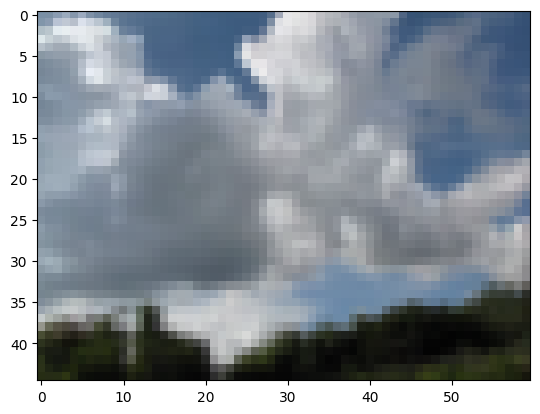

In [51]:
plt.imshow(video_tensor[100].permute(1, 2, 0))
plt.show()

In [52]:
class CloudDataset(Dataset):
    def __init__(self, image_sequence):
        self.ims = image_sequence
        self.ks = 5

    def __len__(self):
        return (self.ims.shape[0] - 1)

    def __getitem__(self, idx):
        return self.ims[idx], self.ims[idx + 1]
    
ds = CloudDataset(video_tensor)
data_loader = DataLoader(ds, batch_size=64, shuffle=True)

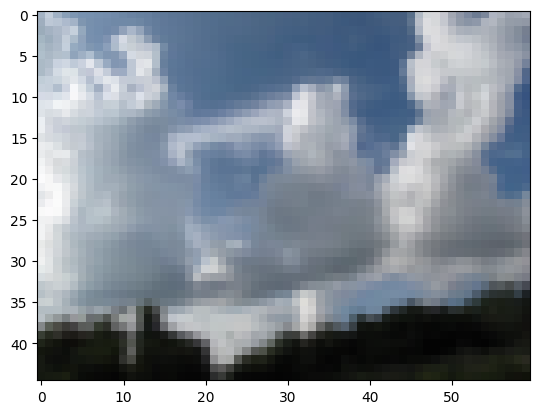

In [53]:
def update(frame):
    global next_frame
    next_frame = ds[frame][0]
    plt.imshow(next_frame.detach().permute(1, 2, 0))

animation = FuncAnimation(plt.gcf(), update, frames=50, repeat=True, interval=50)

from IPython.display import HTML
HTML(animation.to_jshtml())

In [54]:
class Conv(nn.Module):
    def __init__(self, ks=5):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, kernel_size=ks, padding=ks//2, bias=False)
        self.bn = nn.BatchNorm2d(3)

    def forward(self, x):
        xdim = x.dim()
        if xdim == 3:
            x = x.unsqueeze(0)
        x_conv = self.conv(x)
        x_out = self.bn(x_conv)
        if xdim == 3:
            x_out = x_out.squeeze(0)
        return x_out
    
model = Conv()
print(model)

Conv(
  (conv): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [55]:
model = Conv(ks=9)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.007, weight_decay=1e-4)

In [56]:
num_epochs = 220

for epoch in range(num_epochs):
    total_loss = 0.0

    for batch in data_loader:
        input_data = batch[0]
        targets = batch[1]
        
        optimizer.zero_grad()

        outputs = model(input_data)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')

Epoch 1/220, Loss: 0.9574
Epoch 2/220, Loss: 0.7656
Epoch 3/220, Loss: 0.6712
Epoch 4/220, Loss: 0.5835
Epoch 5/220, Loss: 0.5076
Epoch 6/220, Loss: 0.4373
Epoch 7/220, Loss: 0.3757
Epoch 8/220, Loss: 0.3233
Epoch 9/220, Loss: 0.2759
Epoch 10/220, Loss: 0.2344
Epoch 11/220, Loss: 0.1993
Epoch 12/220, Loss: 0.1696
Epoch 13/220, Loss: 0.1431
Epoch 14/220, Loss: 0.1202
Epoch 15/220, Loss: 0.1015
Epoch 16/220, Loss: 0.0856
Epoch 17/220, Loss: 0.0720
Epoch 18/220, Loss: 0.0607
Epoch 19/220, Loss: 0.0506
Epoch 20/220, Loss: 0.0426
Epoch 21/220, Loss: 0.0356
Epoch 22/220, Loss: 0.0300
Epoch 23/220, Loss: 0.0253
Epoch 24/220, Loss: 0.0212
Epoch 25/220, Loss: 0.0181
Epoch 26/220, Loss: 0.0156
Epoch 27/220, Loss: 0.0133
Epoch 28/220, Loss: 0.0115
Epoch 29/220, Loss: 0.0100
Epoch 30/220, Loss: 0.0089
Epoch 31/220, Loss: 0.0080
Epoch 32/220, Loss: 0.0072
Epoch 33/220, Loss: 0.0067
Epoch 34/220, Loss: 0.0062
Epoch 35/220, Loss: 0.0057
Epoch 36/220, Loss: 0.0054
Epoch 37/220, Loss: 0.0051
Epoch 38/2

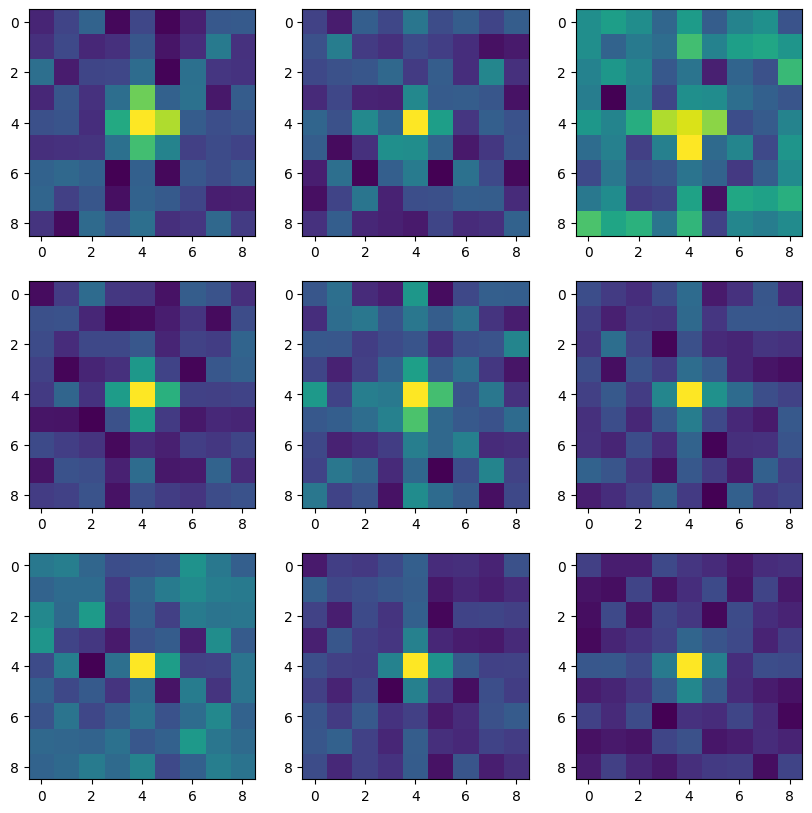

In [57]:
# plot heatmaps of all 9 kernels
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(model.conv.weight[i, j].data.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


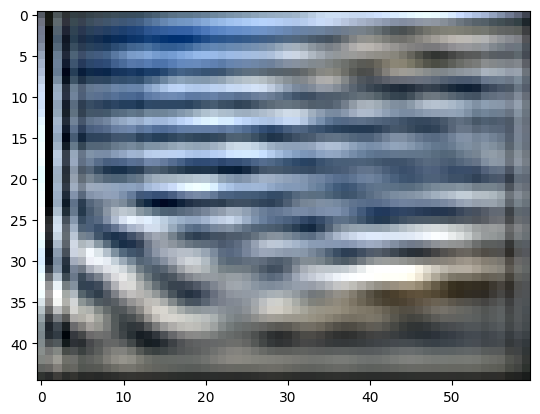

In [58]:
next_frame = ds[-1][0]

def update(frame):
    global next_frame
    # if frame < 50:
    #     plt.imshow(ds[-(50-frame+1)][0].permute(1, 2, 0))
    # else:
    next_frame = model(next_frame)
    plt.imshow(next_frame.detach().permute(1, 2, 0))

animation = FuncAnimation(plt.gcf(), update, frames=100, repeat=True, interval=50)

# save animarion as mp4 video file
# animation.save('conv.mp4', writer='ffmpeg', fps=10, dpi=200)

from IPython.display import HTML
HTML(animation.to_jshtml())